<a href="https://colab.research.google.com/github/akmalrusdy/python/blob/main/KATARAK_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/TA/Dataset/Dataset-Final/80-20'

/content/drive/MyDrive/Colab Notebooks/TA/Dataset/Dataset-Final/80-20


### Gabor Wavelet + SVM

In [4]:
train_imagePaths = paths.list_images("train")
train_data = []
train_labels = []

test_imagePaths = paths.list_images("test")
test_data = []
test_labels = []

In [5]:
def build_filters():
  filters = []
  ksize = 9
  for theta in np.arange(0, np.pi, np.pi / 6):
    kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 3.0, 0.5, 0, ktype=cv2.CV_32F)
    filters.append(kern)
  return filters

In [6]:
def process(img, filters):
 accum = np.zeros_like(img)
 for kern in filters:
  fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
  np.maximum(accum, fimg, accum)
 return accum

In [7]:
filters = build_filters()

for imagePath in train_imagePaths:
  img = cv2.imread(imagePath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64, 64))
 
  fimg = process(img, filters) #feature extraction

  label = imagePath.split(os.path.sep)[-2]
  train_data.append(fimg)
  train_labels.append(label)

for imagePath in test_imagePaths:
  img = cv2.imread(imagePath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64, 64))

  fimg = process(img, filters) #feature extraction

  label = imagePath.split(os.path.sep)[-2]
  test_data.append(fimg)
  test_labels.append(label)

In [8]:
train_data = np.array(train_data) / 255.0 #normalization
trainY = np.array(train_labels)
test_data = np.array(test_data) / 255.0 #normalization
testY = np.array(test_labels)
print(train_data.shape)
print(test_data.shape)

(360, 64, 64, 3)
(90, 64, 64, 3)


In [9]:
nsamples, nx, ny, nz = train_data.shape
trainX = train_data.reshape((nsamples,nx*ny*nz))

nsamples, nx, ny, nz= test_data.shape
testX = test_data.reshape((nsamples,nx*ny*nz))

print(trainX.shape)
print(testX.shape)

(360, 12288)
(90, 12288)


### TRAINING SVM

In [10]:
#%% Train the linear SVM
print(" Training SVM classifier...")
model = SVC(kernel='linear', C=1, gamma=1.0e-3)
%timeit model.fit(trainX, trainY)

 Training SVM classifier...
1.89 s ± 609 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
#%% Evaluate the classifier
print(" Evaluating classifier on train data ...")
predictions = model.predict(trainX)
print(classification_report(trainY, predictions,digits=4))
#%% Evaluate the classifier
print(" Evaluating classifier on test data ...")
predictions1 = model.predict(testX)
print(classification_report(testY, predictions1,digits=4))

 Evaluating classifier on train data ...
              precision    recall  f1-score   support

    immature     1.0000    1.0000    1.0000       120
      mature     1.0000    1.0000    1.0000       120
      normal     1.0000    1.0000    1.0000       120

    accuracy                         1.0000       360
   macro avg     1.0000    1.0000    1.0000       360
weighted avg     1.0000    1.0000    1.0000       360

 Evaluating classifier on test data ...
              precision    recall  f1-score   support

    immature     0.9375    1.0000    0.9677        30
      mature     0.9677    1.0000    0.9836        30
      normal     1.0000    0.9000    0.9474        30

    accuracy                         0.9667        90
   macro avg     0.9684    0.9667    0.9662        90
weighted avg     0.9684    0.9667    0.9662        90



###CONFUSION MATRIX ANALYSIS

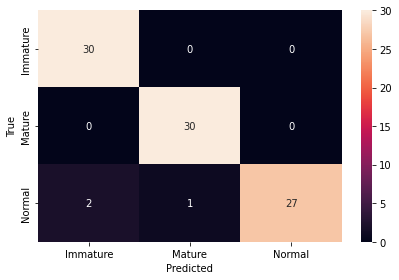

In [ ]:
import sklearn.metrics as metrics
import seaborn as sn
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(testY, predictions1)
x_axis_labels = ['Immature','Mature','Normal']
y_axis_labels = ['Immature','Mature','Normal']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
!pip install memory_profiler
!pip install line_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext memory_profiler
%load_ext line_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
def model_predict(path):
  x = []
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64, 64))
  fimg = process(img, filters)
  x.append(fimg)
  images = np.array(x) / 255.0
  nsamples, nx, ny, nz= images.shape
  images = images.reshape((nsamples,nx*ny*nz))
  classes = model.predict(images)

In [ ]:
test_time_imagePaths = paths.list_images("test")
model_predict_time = []
for imagePath in test_time_imagePaths:
  time =  %timeit -o -n 10 model_predict(imagePath)
  model_predict_time.append(time)

10 loops, best of 5: 11.7 ms per loop
10 loops, best of 5: 12 ms per loop
10 loops, best of 5: 12.3 ms per loop
10 loops, best of 5: 12.8 ms per loop
10 loops, best of 5: 12 ms per loop
10 loops, best of 5: 13.3 ms per loop
10 loops, best of 5: 13.3 ms per loop
10 loops, best of 5: 13.3 ms per loop
10 loops, best of 5: 13.4 ms per loop
10 loops, best of 5: 13.4 ms per loop
10 loops, best of 5: 13.2 ms per loop
10 loops, best of 5: 13.2 ms per loop
10 loops, best of 5: 13.4 ms per loop
10 loops, best of 5: 12.9 ms per loop
10 loops, best of 5: 13.3 ms per loop
10 loops, best of 5: 13.3 ms per loop
10 loops, best of 5: 12.6 ms per loop
10 loops, best of 5: 12.4 ms per loop
10 loops, best of 5: 11.7 ms per loop
10 loops, best of 5: 11.8 ms per loop
10 loops, best of 5: 13 ms per loop
10 loops, best of 5: 11.8 ms per loop
10 loops, best of 5: 12 ms per loop
10 loops, best of 5: 11.8 ms per loop
10 loops, best of 5: 11.5 ms per loop
10 loops, best of 5: 12 ms per loop
10 loops, best of 5: 1

In [ ]:
test_mem_imagePaths = paths.list_images("test")
model_predict_memory_usage = []
for imagePath in test_mem_imagePaths:
  memory =  %memit -o model_predict(imagePath)
  model_predict_memory_usage.append(memory)

peak memory: 347.43 MiB, increment: 0.16 MiB
peak memory: 347.55 MiB, increment: 0.00 MiB
peak memory: 347.55 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.14 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.69 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.02 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memory: 347.71 MiB, increment: 0.00 MiB
peak memor

### UPLOAD IMAGE TEST

Saving 4_jpg.rf.add02ecde6a45264a87bd5109c053e7f.jpg to 4_jpg.rf.add02ecde6a45264a87bd5109c053e7f (2).jpg
(1, 12288)
[[0.41568627 0.61568627 0.55686275 ... 0.54901961 0.40784314 0.36078431]]
['immature']


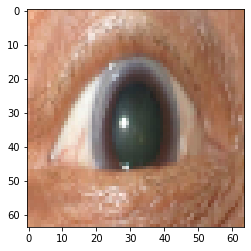

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

uploaded = files.upload()


for fn in uploaded.keys():

  path = fn
  x = [] 
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64, 64))
  fimg = process(img, filters)
  x.append(fimg)
  images = np.array(x) / 255.0
  plt.imshow(img)
  nsamples, nx, ny, nz= images.shape
  images = images.reshape((nsamples,nx*ny*nz))
  classes = model.predict(images)
  print(images.shape)
  print(images)
  print(classes)